# Classification using Decision Trees & Hyper parameter tuning on Titanic Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

# 1) Data Preparation -

###  Information remains the same from last assignment till Section 2
- Import titanic dataset
- analyse the data
- identify the missing values and work on the missing values

## 1.1) Import the data

In [2]:
titanic_df = pd.read_csv('Titanic_original.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1.2) Analyse the data

In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The <b>Survived</b> column is our target/dependent/reponse variable, 1 means the passenger survived, 0 means that the passenger died. 

Several other variables describe the passengers:
- PassengerId: and id given to each traveler on the boat.
- Pclass: the passenger class. It has three possible values: 1,2,3.
- Name
- Sex
- Age
- SibSp: number of siblings and spouses traveling with the passenger
- Parch: number of parents and children traveling with the passenger
- The ticket number
- The ticket fare
- The cabin number
- The port of embarkation. It has three possible values S,C,Q. (C = Cherbourg; Q = Queenstown; S = Southampton) 

Let us check which records in the training data are missing information for the Embarked field. 

# 2) Exploratory Data Analysis

### How many passengers survived and how many died? Is there any relationship with the sex?

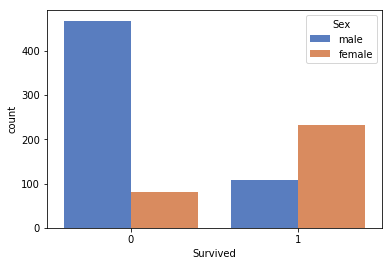

In [4]:
sns.countplot(x='Survived', hue='Sex', data=titanic_df, palette='muted')

### Passenger class and the survival rate

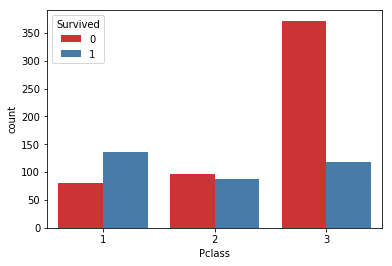

In [5]:
sns.countplot(x='Pclass', hue='Survived', data=titanic_df, palette='Set1')

### Sex and Age - Survival

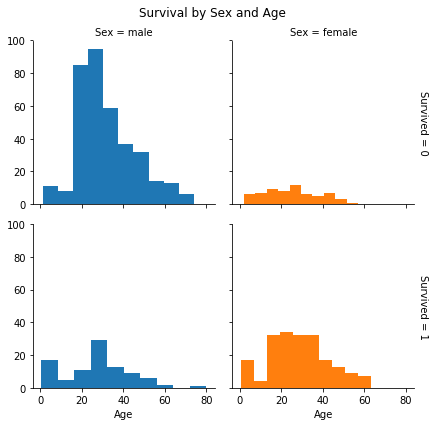

In [6]:
g = sns.FacetGrid(titanic_df, col="Sex", hue='Sex', row="Survived", margin_titles=True)
g.map(plt.hist, "Age");
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Survival by Sex and Age');

### Passenger Class & Age - Survival

Looks like survival rate is more for females compared to males.

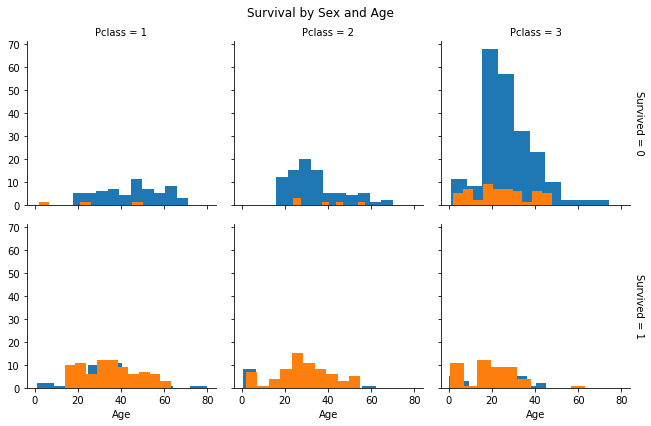

In [7]:
g = sns.FacetGrid(titanic_df, col="Pclass", hue='Sex', row="Survived", margin_titles=True)
g.map(plt.hist, "Age");
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Survival by Sex and Age');

### Fare, Age, Pclass and survival factor

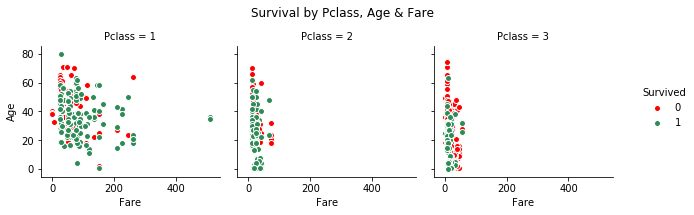

In [8]:
g = sns.FacetGrid(titanic_df, hue="Survived", col="Pclass", margin_titles=True,
                  palette={1:"seagreen", 0:"red"})
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend();
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Survival by Pclass, Age & Fare');

##### Pclass1 survival seems to be more. Pclass2 seems not to make any difference. Pclass3 survival rate is low.

### Fare, Age, Sex and survival factor

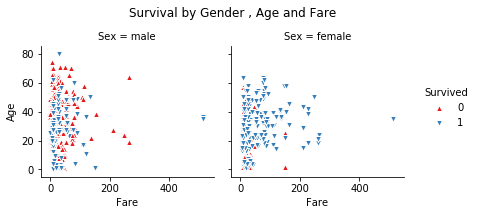

In [9]:
g = sns.FacetGrid(titanic_df, hue="Survived", col="Sex", margin_titles=True,
                palette="Set1",hue_kws=dict(marker=["^", "v"]))
g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Survival by Gender , Age and Fare');

### Correlation 

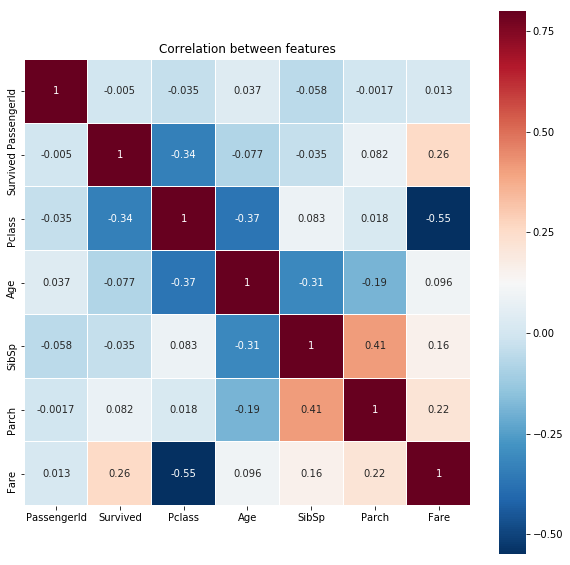

In [10]:
corr=titanic_df.corr()

plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='RdBu_r',linecolor="white")
plt.title('Correlation between features');

In [11]:
corr.Survived

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Name: Survived, dtype: float64

#####  Passenger class and Fare seems to be having higher correlation with the survival rate compared to other features. We need to convert all categorical features to numerical. Lets do that now. 

# 3) Imputation of Missing Data

## 3.1)  Drop the columns where all elements are missing values:

There are 12 columns in total with the following information

In [12]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Find the columns that has null for any columns

In [13]:
titanic_df.columns[titanic_df.isnull().all()].tolist()

[]

##### There are no columns.

## 3.2) Feature Engineering

Before working on missing data, I want to work on creating new features that might be relevant.

- Total number of passengers in the cabin can be found by adding sibsp and parch with the individual (1)
- Individual Fare per passenger can be calculated
- Deck number can be identified from Cabin
- Title can be derived from the name

### 3.2.1) Total Passengers

In [14]:
titanic_df['NumPassengersInCabin'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

### 3.2.2) FarePerPassenger - approximate

In [15]:
titanic_df['FarePerPassenger'] = titanic_df['Fare']/titanic_df['NumPassengersInCabin']

### 3.2.3) Deck

In [16]:
titanic_df['Deck'] = titanic_df.Cabin.str[:1]
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,3.62500,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,35.64165,C


### 3.2.4) Title from Passenger Name

In [17]:
titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
titanic_df[['Name','Title']].head(2)

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs


In [18]:
pd.crosstab(titanic_df['Title'], titanic_df.Sex)

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


The above data seems to be pretty accurate

In [19]:
# Mlle, traditionally given to an unmarried woman.
# Mme for woman - married
titanic_df.Title = titanic_df.Title.replace('Mlle', 'Miss')
titanic_df.Title = titanic_df.Title.replace('Ms', 'Miss')
titanic_df.Title = titanic_df.Title.replace('Mme', 'Mrs')

In [20]:
unc_titles = ['Jonkheer','Col','Capt','Countess','Don','Dona','Dr','Lady','Major','Rev','Sir']

In [21]:
titanic_df['Title'] = titanic_df['Title'].replace(unc_titles, 'Uncommon')

In [22]:
# Lets replace all the other titles as "uncommon"
pd.crosstab(titanic_df['Title'], titanic_df.Sex)

Sex,female,male
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Uncommon,3,20


### 3.2.5) Lone Passenger or Not???!!!

In [23]:
def lonepassenger(passenger):
    if passenger == 1:
        return 'Single'
    else:
        return 'Family'

titanic_df['Single'] = titanic_df.NumPassengersInCabin.apply(lonepassenger)

In [24]:
titanic_df.head(2).T

,0,1
PassengerId,1,2
Survived,0,1
Pclass,3,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th..."
Sex,male,female
Age,22,38
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.2833


## 3.3) Fill Missing values:

In [25]:
titanic_df.isnull().sum()[titanic_df.isnull().sum()>0]

Age         177
Cabin       687
Embarked      2
Deck        687
dtype: int64

#### Age has 177 missing values, Deck 687 and Embarked 2 missing values

### 3.3.1) Missing Data: Embarked

In [26]:
titanic_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


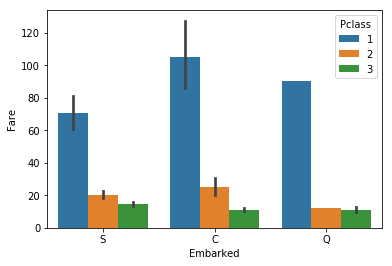

In [27]:
sns.barplot(x="Embarked", y="Fare", hue="Pclass", data=titanic_df);

In [28]:
#Lets check which rows have null Embarked column
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title,Single
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,80.0,B,Miss,Single
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,80.0,B,Mrs,Single


In [29]:
#Pclass1 is missing Embarked values with Fare =80. We need to find the embarkation point for most of passengers with that price range.
# Need not necessarily pclass=1
titanic_df[titanic_df['Pclass']==1]['Embarked'].value_counts()

S    127
C     85
Q      2
Name: Embarked, dtype: int64

In [30]:
titanic_df[['Embarked','Pclass', 'FarePerPassenger']][(titanic_df.FarePerPassenger>75) & (titanic_df.FarePerPassenger <85)]

,Embarked,Pclass,FarePerPassenger
61,NaN,1,80.00000
139,C,1,79.20000
218,C,1,76.29170
256,C,1,79.20000
268,S,1,76.73125
290,S,1,78.85000
310,C,1,83.15830
332,S,1,76.73125
627,S,1,77.95830
681,C,1,76.72920


In [31]:
titanic_df['Embarked'][(titanic_df.FarePerPassenger>75) & (titanic_df.FarePerPassenger <85)].value_counts()

C    6
S    4
Name: Embarked, dtype: int64

#### There are 3 classes S, C, Q 
We can infer that the Embarkation point 'C' is the most occuring for fare price range 75 - 85 (which is also pclass=1). 
Lets replace the missing Embarked values with 'C'

In [32]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('C')

### 3.3.2) Missing Value: Cabin/Deck

In [33]:
titanic_df['Deck'].describe()

count     204
unique      8
top         C
freq       59
Name: Deck, dtype: object

In [34]:
titanic_df['Deck'].isnull().sum()

687

In [35]:
titanic_df[['Pclass', 'Deck']].groupby(['Pclass']).count()

,Deck
Pclass,
1,176
2,16
3,12


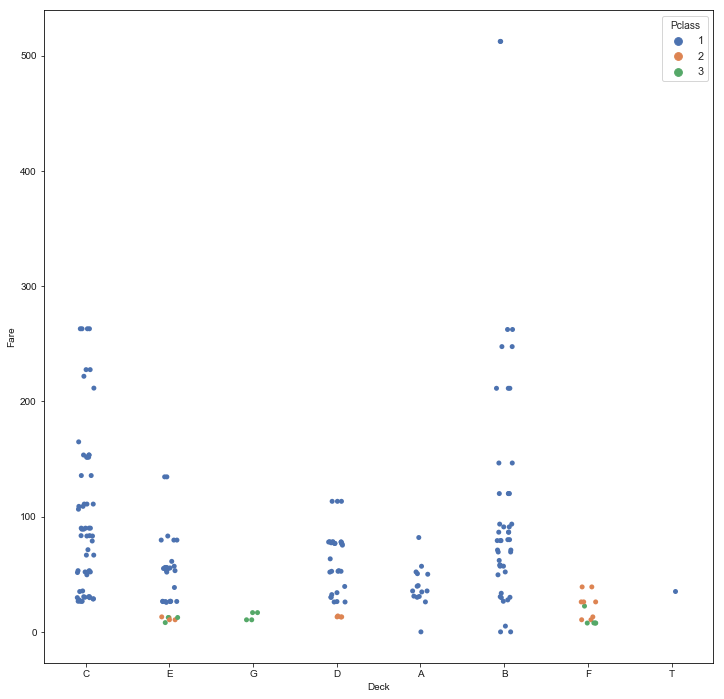

In [36]:
f, ax = plt.subplots(figsize=(12, 12))
sns.set(style="whitegrid")
sns.stripplot('Deck', 'Fare', data=titanic_df, hue='Pclass')

In [37]:
titanic_df[['Deck', 'Pclass', "Fare"]].groupby(['Deck', 'Pclass']).count()

Fare
Deck Pclass      
A    1         15
B    1         47
C    1         59
D    1         29
     2          4
E    1         25
     2          4
     3          3
F    2          8
     3          5
G    3          4
T    1          1

In [38]:
titanic_df.FarePerPassenger[(titanic_df.Deck == 'A') & (titanic_df.Fare !=0)].describe()

count    14.000000
mean     35.108679
std       9.823917
min      19.800000
25%      28.848450
50%      32.827100
75%      38.968750
max      52.000000
Name: FarePerPassenger, dtype: float64

In [39]:
titanic_df.Fare[(titanic_df.Deck == 'B') & (titanic_df.Fare !=0)].describe()

count     45.000000
mean     118.550464
std      108.987208
min        5.000000
25%       57.979200
50%       80.000000
75%      120.000000
max      512.329200
Name: Fare, dtype: float64

In [40]:
titanic_df[['Deck', 'FarePerPassenger']][titanic_df.Deck == 'G'].describe()

,FarePerPassenger
count,4.000000
mean,4.963021
std,0.996307
min,3.487500
25%,4.795313
50%,5.398958
75%,5.566667
max,5.566667


### Calculating approximate fare rates for each deck based on the 25th and 75th percentile of IQR

In [41]:
DeckAFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='A'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='A'], 75))/2

DeckBFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='B'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='B'], 75))/2

DeckCFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='C'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='C'], 75))/2

DeckDFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='D'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='D'], 75))/2

DeckEFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='E'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='E'], 75))/2

DeckFFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='F'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='F'], 75))/2

DeckGFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='G'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='G'], 75))/2

DeckTFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='T'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='T'], 75))/2
print("DeckAFare=",DeckAFare,"DeckBFare=", DeckBFare, "DeckCFare=",DeckCFare, "DeckDFare=",DeckDFare)
print("DeckEFare=",DeckEFare, "DeckFFare=",DeckFFare, "DeckGFare=", DeckGFare, "DeckTFare=",DeckTFare)

DeckAFare= 32.843925 DeckBFare= 55.9974 DeckCFare= 40.37605 DeckDFare= 32.454175
DeckEFare= 26.945318750000002 DeckFFare= 8.7 DeckGFare= 5.180989583333334 DeckTFare= 35.5


### THE DECKS WITH LOWER TO HIGHER RATES ARE
DECKG   
DECKF  
DECKE   
DECKD  
DECKA  
DESCT  
DECKC  
DECKB  

Lets populate the values of deck starting from low value

The decks will be populated based on the fare range of the decks as calculated above.

In [42]:
### populate the Deck values based on the fare range ###
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > 0) & (titanic_df.FarePerPassenger <= DeckGFare)] = titanic_df.Deck.fillna('G')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckGFare) & (titanic_df.FarePerPassenger <= DeckFFare)] = titanic_df.Deck.fillna('F')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckFFare) & (titanic_df.FarePerPassenger <= DeckEFare)] = titanic_df.Deck.fillna('E')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckEFare) & (titanic_df.FarePerPassenger <= DeckDFare)] = titanic_df.Deck.fillna('D')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckDFare) & (titanic_df.FarePerPassenger <= DeckAFare)] = titanic_df.Deck.fillna('A')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckAFare) & (titanic_df.FarePerPassenger <= DeckTFare)] = titanic_df.Deck.fillna('T')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckTFare) & (titanic_df.FarePerPassenger <= DeckCFare)] = titanic_df.Deck.fillna('C')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckCFare)] = titanic_df.Deck.fillna('B')

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
titanic_df[['Pclass','FarePerPassenger','Deck']][titanic_df.Deck.isnull()]

,Pclass,FarePerPassenger,Deck
179,3,0.0,NaN
271,3,0.0,NaN
277,2,0.0,NaN
302,3,0.0,NaN
413,2,0.0,NaN
466,2,0.0,NaN
481,2,0.0,NaN
597,3,0.0,NaN
633,1,0.0,NaN
674,2,0.0,NaN


In [44]:
#Drop off all the rows wwith passenger fare = 0
titanic_df = titanic_df[titanic_df.FarePerPassenger > 0]
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title,Single
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,3.62500,G,Mr,Family
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,35.64165,C,Mrs,Family


In [45]:
titanic_df.shape

(876, 17)

### 3.3.3) Missing Data: Age

In [46]:
titanic_df['Age'].describe()

count    707.000000
mean      29.645219
std       14.558872
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

#### Age ranges from less than 1 to 80 years old with mean age as 30.
Most of the passenger ages are in the range of 21 to 39

Text(0,0.5,'Frequency')

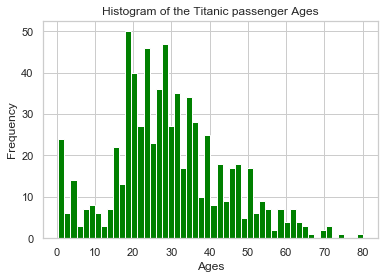

In [47]:
titanic_df['Age'].plot.hist(bins=50, color='green')
Title = 'Histogram of the Titanic passenger Ages'
X = 'Ages'
y = 'Frequency'
plt.title(Title)
plt.xlabel(X)
plt.ylabel(y)     

#### I want to specify the Age based on the Title from the name
Age for all titles with Mr will be the mean of all titles with Mr.

In [48]:
titles = ['Master', 'Miss', 'Mr', 'Mrs']
titanic_df[(titanic_df['Title']== 'Uncommon')& (titanic_df['Age'].isnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title,Single
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6,NaN,C,1,39.6,C,Uncommon,Single


Only one missing info for the title Uncommon (Dr)

In [49]:
titanic_df[(titanic_df['Title'] == 'Uncommon')]['Age'].mean()

45.904761904761905

In [50]:
titanic_df.Age.loc[titanic_df['Title'] == 'Uncommon'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Uncommon')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [51]:
titanic_df[(titanic_df['Title'] == 'Master')]['Age'].mean()

4.574166666666667

In [52]:
titanic_df[(titanic_df['Title'] == 'Mrs')]['Age'].mean()

35.788990825688074

In [53]:
titanic_df.Age.loc[titanic_df['Title'] == 'Master'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Master')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [54]:
titanic_df.Age.loc[titanic_df['Title'] == 'Mr'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Mr')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [55]:
titanic_df.Age.loc[titanic_df['Title'] == 'Miss'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Miss')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [56]:
titanic_df.Age.loc[titanic_df['Title'] == 'Mrs'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Mrs')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [57]:
titanic_df.Age.isnull().sum()

0

Text(0,0.5,'Frequency')

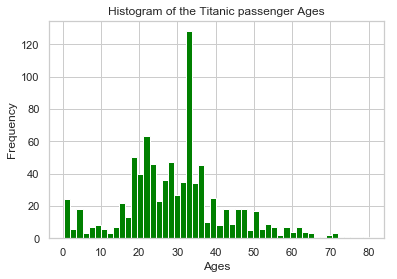

In [58]:
titanic_df['Age'].plot.hist(bins=50, color='green')
Title = 'Histogram of the Titanic passenger Ages'
X = 'Ages'
y = 'Frequency'
plt.title(Title)
plt.xlabel(X)
plt.ylabel(y)     

## 3.4) Drop off unwanted columns

In [59]:
titanic_df.head(2).T

,0,1
PassengerId,1,2
Survived,0,1
Pclass,3,1
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th..."
Sex,male,female
Age,22,38
SibSp,1,1
Parch,0,0
Ticket,A/5 21171,PC 17599
Fare,7.25,71.2833


Drop off the following columns:  
Name  
Ticket  
Cabin  
SibSp  
Parch  

In [60]:
titanic_df = titanic_df.drop(columns = ['Name', 'Ticket', 'Cabin', 'FarePerPassenger', 'SibSp', 'Parch'])
titanic_df.head(3)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,NumPassengersInCabin,Deck,Title,Single
0,1,0,3,male,22.0,7.2500,S,2,G,Mr,Family
1,2,1,1,female,38.0,71.2833,C,2,C,Mrs,Family
2,3,1,3,female,26.0,7.9250,S,1,F,Miss,Single


## 3.5) Convert categorical to numerical 

In [61]:
titanic_df = pd.get_dummies(data=titanic_df, columns=['Sex', 'Embarked', 'Deck', 'Title', 'Single'])
titanic_df.tail(3)

,PassengerId,Survived,Pclass,Age,Fare,NumPassengersInCabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Deck_F,Deck_G,Deck_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Uncommon,Single_Family,Single_Single
888,889,0,3,21.845638,23.45,4,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
889,890,1,1,26.000000,30.00,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,1
890,891,0,3,32.000000,7.75,1,0,1,0,1,...,1,0,0,0,0,1,0,0,0,1


## 3.6) Statistical summary of the prepared dataset: 
Numerical variables

In [62]:
titanic_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,876.0,444.794521,257.806393,1.0000,220.750000,444.5,667.250000,891.0000
Survived,876.0,0.389269,0.487863,0.0000,0.000000,0.0,1.000000,1.0000
Pclass,876.0,2.315068,0.835663,1.0000,2.000000,3.0,3.000000,3.0000
Age,876.0,29.688562,13.354711,0.4200,21.845638,30.0,35.788991,80.0000
Fare,876.0,32.755650,49.936826,4.0125,7.925000,14.5,31.275000,512.3292
NumPassengersInCabin,876.0,1.920091,1.622839,1.0000,1.000000,1.0,2.000000,11.0000
Sex_female,876.0,0.358447,0.479818,0.0000,0.000000,0.0,1.000000,1.0000
Sex_male,876.0,0.641553,0.479818,0.0000,0.000000,1.0,1.000000,1.0000
Embarked_C,876.0,0.194064,0.395704,0.0000,0.000000,0.0,0.000000,1.0000
Embarked_Q,876.0,0.087900,0.283311,0.0000,0.000000,0.0,0.000000,1.0000


### 3.6.1) Correlation of features against Survival

In [63]:
tcorr = titanic_df.corr()

#### The following are the key features that impact the survival of the passenger

In [64]:
tcorr.Survived[(abs(tcorr.Survived) >.15) & (abs(tcorr.Survived != 1))] 

Pclass          -0.351636
Fare             0.252453
Sex_female       0.540800
Sex_male        -0.540800
Embarked_C       0.170640
Embarked_S      -0.150117
Deck_B           0.200415
Deck_F          -0.225896
Title_Miss       0.332615
Title_Mr        -0.548314
Title_Mrs        0.339935
Single_Family    0.196560
Single_Single   -0.196560
Name: Survived, dtype: float64

In [65]:
tcorr.Survived[(abs(tcorr.Survived) <=.15) & (abs(tcorr.Survived != 1))] 

PassengerId             0.000246
Age                    -0.085192
NumPassengersInCabin    0.010464
Embarked_Q              0.000217
Deck_A                  0.028942
Deck_C                  0.107926
Deck_D                  0.127671
Deck_E                  0.026985
Deck_G                 -0.045923
Deck_T                  0.010864
Title_Master            0.083322
Title_Uncommon         -0.008438
Name: Survived, dtype: float64

In [66]:
bkpt = titanic_df.copy()

corrcols = tcorr.Survived[(abs(tcorr.Survived) >.15)].index.tolist()
titanic_df = titanic_df[corrcols]

In [67]:
titanic_df.head()

,PassengerId,Survived,Pclass,Age,Fare,NumPassengersInCabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Deck_F,Deck_G,Deck_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Uncommon,Single_Family,Single_Single
0,1,0,3,22.0,7.2500,2,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
1,2,1,1,38.0,71.2833,2,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
2,3,1,3,26.0,7.9250,1,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3,4,1,1,35.0,53.1000,2,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,5,0,3,35.0,8.0500,1,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1


## 2) Decision Trees - Default Parameters

This is binary classification supervised problem

In [68]:
# Importing modules
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score

In [116]:
X = titanic_df.drop(['Survived', 'PassengerId'], axis=1)
y = titanic_df.Survived

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(613, 24) (613,) (263, 24) (263,)


In [118]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)

dt_predicted= dt.predict(X_test)

# Score for train and test
dt_train_score = round(dt.score(X_train, y_train) * 100, 2)
dt_test_score = round(dt.score(X_test, y_test) * 100, 2)

In [119]:
print('Decision Tree Training Score: \n', dt_train_score)
print('Decision Tree Test Score: \n', dt_test_score)

Decision Tree Training Score: 
 98.69
Decision Tree Test Score: 
 74.9


In [120]:
print('Decision Tree Accuracy: \n', accuracy_score(y_test, dt_predicted))
print('Confusion Matrix: \n', confusion_matrix(y_test, dt_predicted))
print('Classification Report: \n', classification_report(y_test, dt_predicted))

Decision Tree Accuracy: 
 0.7490494296577946
Confusion Matrix: 
 [[128  35]
 [ 31  69]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.81      0.79      0.80       163
          1       0.66      0.69      0.68       100

avg / total       0.75      0.75      0.75       263



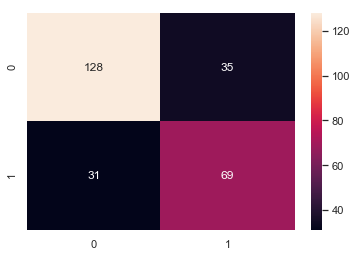

In [121]:
sns.heatmap(confusion_matrix(y_test, dt_predicted),annot=True,fmt="d")

# 3) Hyper parameter tuning

Objective is:
- use GridSearchCV to fit the decision tree classifier with a dictionary of values
- execute gridsearch for different cross validation values (cv)
- Identify the best value for the hyper parameter (in our case, C) using the accuracy score.
- For different values of C, evaluate the model with L1 and L2 penalty, plot accuracy vs different C values
- Note down accuracy, sensitivity, selectivity, F1-score for all combinations and pick the final model.
- Asses the performance of the chosen model and explain.

## 3.1) GridSearchCV for cross validation (cv) = 5 and different hyper parameters

In [122]:
dtcv5 = DecisionTreeClassifier()

criterion : "gini" for the Gini impurity and "entropy" for the information gain.  
splitter : Supported strategies are "best" to choose the best split and "random" to choose the best random split.  
max_depth : The maximum depth of the tree.   
min_samples_split : The minimum number of samples required to split an internal node  
min_samples_leaf : The minimum number of samples required to be at a leaf node
min_weight_fraction_leaf : The minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node.   
max_features : The number of features to consider when looking for the best split:
        - If int, then consider `max_features` features at each split.
        - If float, then `max_features` is a percentage and
          `int(max_features * n_features)` features are considered at each
          split.
        - If "auto", then `max_features=sqrt(n_features)`.
        - If "sqrt", then `max_features=sqrt(n_features)`.
        - If "log2", then `max_features=log2(n_features)`.
max_leaf_nodes : Grow a tree with ``max_leaf_nodes`` in best-first fashion.
min_impurity_decrease : A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [123]:
# Define different hyperparameters for decision tree
hparameters = [{'criterion': ['gini', 'entropy']}, {'max_depth': [2, 3, 5, 10]}, {'min_samples_split': [2, 3, 5]},
              {'min_samples_leaf': [1, 5, 8]}, {'max_features': ['auto', 'log2', 'sqrt']}]

In [124]:
grid_searchcv5 = GridSearchCV(estimator = dtcv5, param_grid = hparameters, cv=5, verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [125]:
grid_searchcv5.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    5.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['gini', 'entropy']}, {'max_depth': [2, 3, 5, 10]}, {'min_samples_split': [2, 3, 5]}, {'min_samples_leaf': [1, 5, 8]}, {'max_features': ['auto', 'log2', 'sqrt']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [126]:
grid_searchcv5.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [127]:
grid_searchcv5.best_params_

{'min_samples_leaf': 5}

In [128]:
grid_searchcv5.best_score_

0.8221859706362153

### Per Grid Search the best estimator is criterion='gini', max_depth=5, max_features=None,            min_samples_leaf=1, min_samples_split=2 for cv=5

In [129]:
clf5 = grid_searchcv5.best_estimator_
clf5.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Feature Importance

In [132]:
feature_importance = clf5.feature_importances_.tolist()
pd.DataFrame(X_train.columns, feature_importance).head()

,0
0.161154,Pclass
0.111763,Age
0.080345,Fare
0.079302,NumPassengersInCabin
0.000000,Sex_female


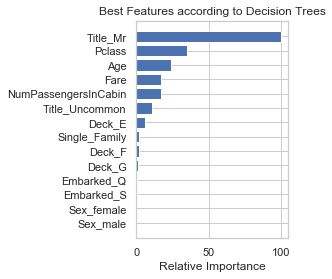

In [133]:
# #############################################################################
feature_names = np.asarray(X.columns.tolist())
# Plot feature importance
feature_importance = clf5.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[10:].shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx[10:]], align='center')
plt.yticks(pos,feature_names[sorted_idx[10:]]) 
plt.xlabel('Relative Importance')
plt.title('Best Features according to Decision Trees')
plt.show()

### Predictions

In [134]:
# Predict the test values
gspredcv5 = clf5.predict(X_test)

In [135]:
gscv5_acc = accuracy_score(y_test, gspredcv5)
gscv5_pr = precision_score(y_test, gspredcv5, average='weighted')
gscv5_rec = recall_score(y_test, gspredcv5, average='weighted')
gscv5_f1 = f1_score(y_test, gspredcv5, average='weighted')
gscv5_cm = confusion_matrix(y_test, gspredcv5)
gscv5_cr = classification_report(y_test, gspredcv5)

In [136]:
print("criterion='gini', max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2 for cv=5")
print("==================================================================================================")
print('Accuracy: \n', round(gscv5_acc,2))
print('Precision: \n', round(gscv5_pr,2))
print('Recall: \n', round(gscv5_rec,2))
print('F1 Score: \n', round(gscv5_f1,2))
print('Confusion Matrix: \n', gscv5_cm)
print('Classification Report: \n', gscv5_cr)

criterion='gini', max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2 for cv=5
Accuracy: 
 0.82
Precision: 
 0.82
Recall: 
 0.82
F1 Score: 
 0.82
Confusion Matrix: 
 [[142  21]
 [ 27  73]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.84      0.87      0.86       163
          1       0.78      0.73      0.75       100

avg / total       0.82      0.82      0.82       263



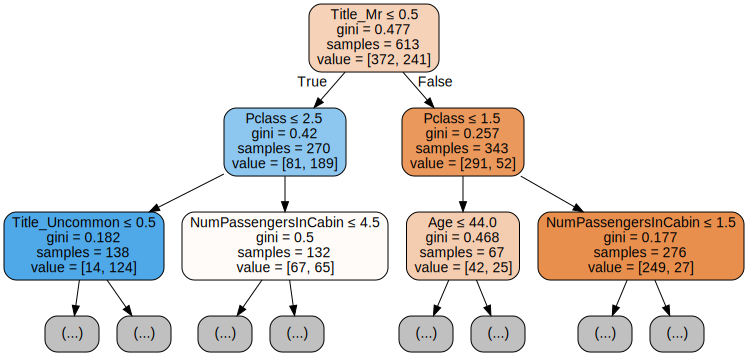

In [171]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.tree import export_graphviz
graph = Source(export_graphviz(clf5, out_file=None, max_depth=2,
                feature_names=X_train.columns, filled=True, rounded=True,
                special_characters=True))

display(SVG(graph.pipe(format='svg')))

## 3.2) GridSearchCV for cross validation (cv) = 10 and different hyper parameters

In [137]:
dtcv10 = DecisionTreeClassifier()

In [138]:
grid_searchcv10 = GridSearchCV(estimator = dtcv10, param_grid = hparameters, cv=10, verbose = 1,
                           n_jobs = -1, return_train_score = True)

In [139]:
grid_searchcv10.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    5.1s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['gini', 'entropy']}, {'max_depth': [2, 3, 5, 10]}, {'min_samples_split': [2, 3, 5]}, {'min_samples_leaf': [1, 5, 8]}, {'max_features': ['auto', 'log2', 'sqrt']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [140]:
grid_searchcv10.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [141]:
grid_searchcv10.best_params_

{'max_depth': 3}

In [142]:
grid_searchcv10.best_score_

0.8270799347471451

### Per Grid Search the best estimator is criterion='gini', max_depth=3, max_features=None,            min_samples_leaf=1, min_samples_split=2 for cv=10

In [143]:
grid_searchcv10.score(X_train, y_train), grid_searchcv10.score(X_test, y_test)

(0.835236541598695, 0.8174904942965779)

In [144]:
clf10 = grid_searchcv10.best_estimator_
clf10.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Feature Importance

In [145]:
feature_importance = clf10.feature_importances_.tolist()
pd.DataFrame(X_train.columns, feature_importance).head()

,0
0.204393,Pclass
0.016107,Age
0.000000,Fare
0.091494,NumPassengersInCabin
0.000000,Sex_female


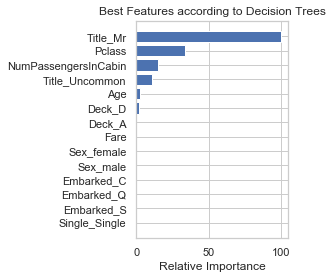

In [146]:
# #############################################################################
feature_names = np.asarray(X.columns.tolist())
# Plot feature importance
feature_importance = clf10.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx[10:].shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx[10:]], align='center')
plt.yticks(pos,feature_names[sorted_idx[10:]]) 
plt.xlabel('Relative Importance')
plt.title('Best Features according to Decision Trees')
plt.show()

### Predictions

In [147]:
# Predict the test values
gspredcv10 = clf10.predict(X_test)

In [148]:
gscv10_acc = accuracy_score(y_test, gspredcv10)
gscv10_pr = precision_score(y_test, gspredcv10, average='weighted')
gscv10_rec = recall_score(y_test, gspredcv10, average='weighted')
gscv10_f1 = f1_score(y_test, gspredcv10, average='weighted')
gscv10_cm = confusion_matrix(y_test, gspredcv10)
gscv10_cr = classification_report(y_test, gspredcv10)

In [149]:
print("criterion='gini', max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2 for cv=10")
print("==================================================================================================")
print('Accuracy: \n', round(gscv10_acc,2))
print('Precision: \n', round(gscv10_pr,2))
print('Recall: \n', round(gscv10_rec,2))
print('F1 Score: \n', round(gscv10_f1,2))
print('Confusion Matrix: \n', gscv10_cm)
print('Classification Report: \n', gscv10_cr)

criterion='gini', max_depth=3, max_features=None, min_samples_leaf=1, min_samples_split=2 for cv=10
Accuracy: 
 0.82
Precision: 
 0.82
Recall: 
 0.82
F1 Score: 
 0.81
Confusion Matrix: 
 [[145  18]
 [ 30  70]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.83      0.89      0.86       163
          1       0.80      0.70      0.74       100

avg / total       0.82      0.82      0.81       263



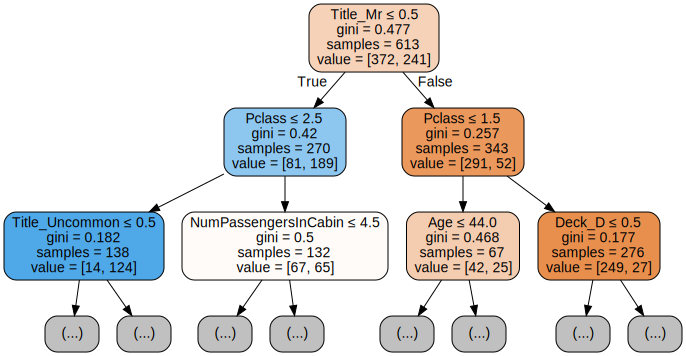

In [172]:
graph = Source(export_graphviz(clf10, out_file=None, max_depth=2,
                feature_names=X_train.columns, filled=True, rounded=True,
                special_characters=True))

display(SVG(graph.pipe(format='svg')))

# 4) Conclusion 

### 1) The important features for different values of cv differs
### 2) Increase in cv has resulted in more accuracy as well
### 3) The decision tree breakdown of the features differs for different CV. This indicates the the logic of processing the features is different.
### 4) best param values are different. Eg) max_depth. 